In [1]:
import qubx

%qubxd

%load_ext autoreload
%autoreload 2

from typing import cast
import numpy as np
import pandas as pd
import asyncio
from pathlib import Path
from qubx.core.lookups import lookup
from qubx.connectors.ccxt.factory import get_ccxt_exchange
from qubx import logger, QubxLogConfig
from qubx.core.interfaces import IStrategy, IStrategyContext, BaseErrorEvent, IStrategyInitializer
from qubx.utils.runner.runner import run_strategy, StrategyConfig, AccountConfigurationManager, ExchangeConfig, LoggingConfig
from qubx.utils.runner.configs import LiveConfig, ReaderConfig
from qubx.core.basics import DataType, MarketEvent
from qubx.utils.charting.lookinglass import LookingGlass

QubxLogConfig.set_log_level("INFO")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.91
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


## 1.0 Define simple strategy that does nothing

Just subscribes to OHLC[1h], orderbook aggregated in 0.01% buckets top 100 levels (1% depth).

In [2]:
class TestStrategy(IStrategy):

    def on_init(self, initializer: IStrategyInitializer):
        initializer.set_base_subscription(DataType.TRADE)
        initializer.set_subscription_warmup({
            DataType.OHLC["1h"]: "1d"
        })
    
    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        pass

    def on_error(self, ctx: IStrategyContext, error: BaseErrorEvent) -> None:
        logger.error(f"Error: {error}")

    def on_stop(self, ctx: IStrategyContext):
        logger.info("Stopping test strategy")

In [ ]:
ctx = run_strategy(
    config=StrategyConfig(
        name="TestStrategy",
        strategy=TestStrategy,
        aux=ReaderConfig(reader="xlighter", args={"max_history": "10d"}),
        live=LiveConfig(
            exchanges={
                "LIGHTER": ExchangeConfig(
                    connector="xlighter",
                    universe=["BTCUSDC", "ETHUSDC"],
                )
            },
            logging=LoggingConfig(
                logger="InMemoryLogsWriter",
                position_interval="10s",
                portfolio_interval="1m",
                heartbeat_interval="10m",
            )
        )
    ),
    account_manager=AccountConfigurationManager(search_qubx_dir=True),
    paper=True,
    blocking=False,
)

2025-10-10 13:07:07.608 [ℹ️] Initialized LighterClient (testnet=False, account_index=0, api_key_index=0)
2025-10-10 13:07:07.609 [ℹ️] Loading instruments from Lighter API...
2025-10-10 13:07:08.870 [ℹ️] Found 92 markets
2025-10-10 13:07:08.871 [ℹ️] Successfully loaded 92 instruments
2025-10-10 13:07:08.873 [ℹ️] XLighterDataReader initialized: 92 instruments loaded, max_history=10d
2025-10-10 13:07:09.407 [ℹ️] Initialized LighterClient (testnet=False, account_index=0, api_key_index=0)
2025-10-10 13:07:09.408 [ℹ️] Loading instruments from Lighter API...
2025-10-10 13:07:10.608 [ℹ️] Found 92 markets
2025-10-10 13:07:10.610 [ℹ️] Successfully loaded 92 instruments
2025-10-10 13:07:10.611 [ℹ️] LighterDataProvider initialized
2025-10-10 13:07:10.612 [ℹ️] - Strategy: TestStrategy
- Mode: paper
- Parameters: {}
2025-10-10 13:07:10.638 [ℹ️] Starting warmup for 2 configurations
2025-10-10 13:07:10.899 [ℹ️] OHLC warmup for BTCUSDC: loaded 24 1h bars
2025-10-10 13:07:11.151 [ℹ️] OHLC warmup for ETH

2025-10-10 13:07:11.558 [ℹ️] Waiting for all instruments (0/2 ready). Missing: ['BTCUSDC', 'ETHUSDC']. Will start with partial data in 60s
2025-10-10 13:07:11.559 [ℹ️] Heartbeat at 2025-10-10T13:00:00
2025-10-10 13:07:12.241 [ℹ️] Connected to wss://mainnet.zklighter.elliot.ai/stream
2025-10-10 13:07:12.242 [ℹ️] WebSocket connected successfully
2025-10-10 13:07:12.244 [ℹ️] Lighter WebSocket connected
2025-10-10 13:07:13.306 [ℹ️] All 2 instruments have data - strategy ready to start
2025-10-10 13:07:44.439 [ℹ️] Subscribed to orderbook(0.01, 10) for 2 instruments: ['BTCUSDC', 'ETHUSDC']
2025-10-10 13:07:57.422 [ℹ️] Starting warmup for 5 configurations
2025-10-10 13:07:58.723 [ℹ️] OHLC warmup for LINKUSDC: loaded 24 1h bars
2025-10-10 13:07:59.027 [ℹ️] OHLC warmup for DOGEUSDC: loaded 24 1h bars
2025-10-10 13:07:59.282 [ℹ️] OHLC warmup for SOLUSDC: loaded 24 1h bars
2025-10-10 13:07:59.744 [ℹ️] OHLC warmup for XRPUSDC: loaded 24 1h bars
2025-10-10 13:08:00.286 [ℹ️] OHLC warmup for ADAUSDC:

In [9]:
ctx.subscribe(DataType.ORDERBOOK[0.01, 10])

In [14]:
add_symbols = ["BTCUSDC", "ETHUSDC", "XRPUSDC", "SOLUSDC", "DOGEUSDC", "ADAUSDC", "LINKUSDC", "XPLUSDC", "HYPEUSDC"]
add_instruments = [ctx.query_instrument(symbol) for symbol in add_symbols]
print(add_instruments)
ctx.set_universe(add_instruments)

[LIGHTER:SWAP:BTCUSDC, LIGHTER:SWAP:ETHUSDC, LIGHTER:SWAP:XRPUSDC, LIGHTER:SWAP:SOLUSDC, LIGHTER:SWAP:DOGEUSDC, LIGHTER:SWAP:ADAUSDC, LIGHTER:SWAP:LINKUSDC, LIGHTER:SWAP:XPLUSDC, LIGHTER:SWAP:HYPEUSDC]


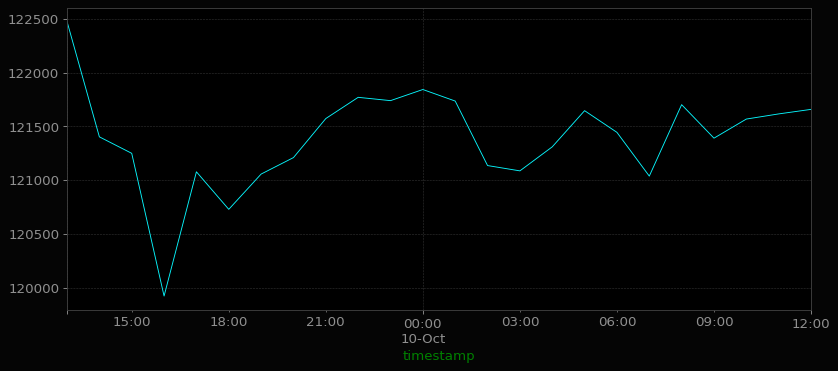

In [25]:
ctx.ohlc(ctx.query_instrument("BTCUSDC"), "1h").pd()["close"].plot();

In [18]:
ctx.quote(ctx.query_instrument("XPLUSDC"))

[2025-10-10T13:08:47.490000000]	0.73057 (94870.20) | 0.73090 (23386.50)

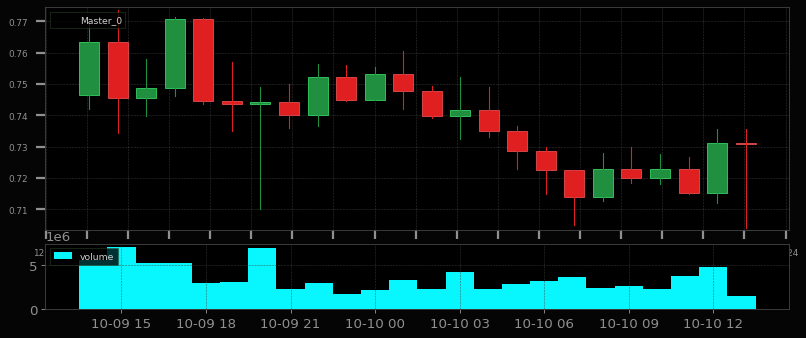

In [15]:
ohlc = ctx.ohlc(ctx.query_instrument("XPLUSDC"), "1h").pd()

LookingGlass(
    ohlc,
    {
        "volume": ["bars", ohlc["volume"]],
    },
    backend="mpl",
).look()

In [9]:
ctx.stop()

(<Figure size 960x640 with 1 Axes>,
 <Axes: title={'center': 'Order Book - $4357.00 | $4357.16 (Spread: $0.16)'}, xlabel='Cumulative Volume', ylabel='Price'>)

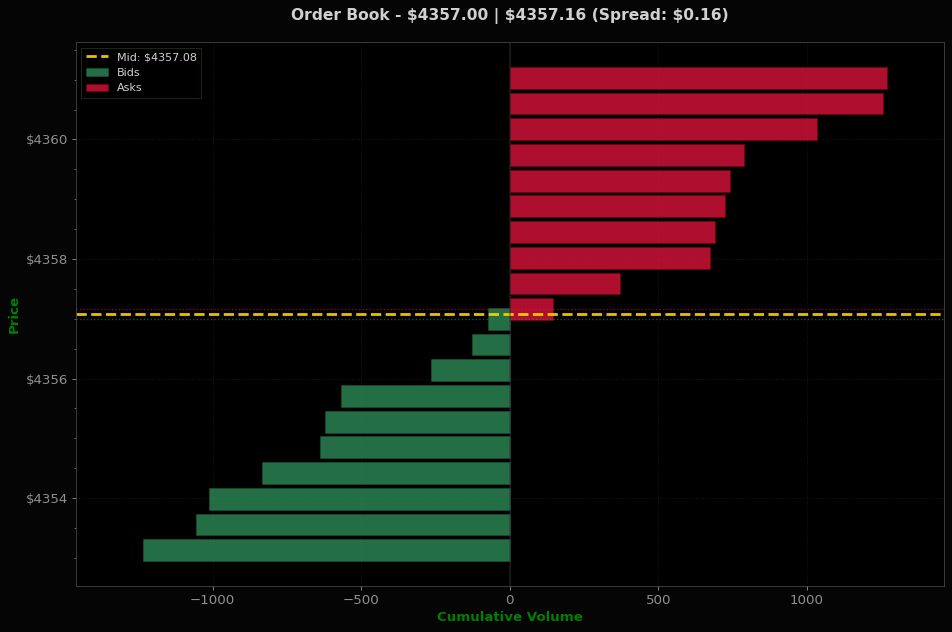

In [19]:
from qubx.utils.charting.orderbook import plot_orderbook

plot_orderbook(
    (ob:=ctx.get_data(ctx.query_instrument("ETHUSDC"), DataType.ORDERBOOK)[-1]),
    cumulative=True
)

In [ ]:
ctx.stop()